<a href="https://colab.research.google.com/github/zhulkhoirr/Steam-Recommendation-System/blob/main/SteamRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Game Pada Platform Steam

## 1. Download Datasets Dari Kaggle

In [ ]:
from google.colab import files
files.upload()

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
 98% 649M/660M [00:11<00:00, 33.4MB/s]
100% 660M/660M [00:11<00:00, 62.6MB/s]


In [6]:
!unzip -q game-recommendations-on-steam.zip

## 2. EDA

In [7]:
import numpy as np
import pandas as pd

In [8]:
games_df = pd.read_csv('games.csv')

games_df.sample(5)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
43455,1488750,VR Immortal Fight,2021-08-05,True,False,False,Positive,86,29,4.99,4.99,0.0,True
37982,1821630,They Сame From Above,2021-12-01,True,False,False,Mixed,64,14,2.49,24.99,90.0,True
3950,1531040,Pavlov's House,2021-02-26,True,True,False,Positive,100,40,8.99,8.99,0.0,True
31893,387100,Walkerman,2017-05-22,True,True,True,Positive,81,32,6.99,6.99,0.0,True
2100,446540,Smash Up,2017-10-12,True,False,False,Mixed,55,100,6.99,6.99,0.0,True


In [9]:
len(games_df)

50872

In [10]:
sort_games_df = games_df.sort_values(by='user_reviews', ascending=False)

sort_games_df.head(10)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
14398,730,Counter-Strike: Global Offensive,2012-08-21,True,True,True,Very Positive,88,7494460,15.0,0.0,0.0,True
47770,578080,PUBG: BATTLEGROUNDS,2017-12-21,True,False,False,Mixed,57,2217226,0.0,0.0,0.0,True
13176,570,Dota 2,2013-07-09,True,True,True,Very Positive,82,2045628,0.0,0.0,0.0,True
12717,271590,Grand Theft Auto V,2015-04-13,True,False,False,Very Positive,86,1484122,0.0,0.0,0.0,True
14535,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,True,False,False,Very Positive,86,993312,20.0,0.0,0.0,True
47380,440,Team Fortress 2,2007-10-10,True,True,True,Very Positive,93,985819,0.0,0.0,0.0,True
13035,105600,Terraria,2011-05-16,True,True,True,Overwhelmingly Positive,97,943413,10.0,0.0,0.0,True
15363,4000,Garry's Mod,2006-11-29,True,True,True,Overwhelmingly Positive,96,853733,10.0,0.0,0.0,True
13173,252490,Rust,2018-02-08,True,True,False,Very Positive,87,786668,40.0,0.0,0.0,True
14376,1172470,Apex Legends™,2020-11-04,True,False,False,Very Positive,80,713182,0.0,0.0,0.0,True


In [11]:
users_df = pd.read_csv('users.csv')

users_df.sample(5)

,user_id,products,reviews
6972577,7089167,50,1
1269470,12994765,26,2
3296137,9745666,87,1
11243309,13971028,347,17
2302779,13839780,934,4


In [12]:
recommendations_df = pd.read_csv('recommendations.csv')

recommendations_df.sample(5)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
24684608,24200,0,0,2015-05-03,True,479.7,6166011,24684608
116148,1086940,0,0,2021-03-03,True,87.6,7256103,116148
6344234,244850,0,0,2016-01-09,True,36.2,4808342,6344234
36544149,1046930,0,2,2019-06-29,True,86.0,5524235,36544149
748103,1174180,0,0,2022-10-07,True,44.0,1864729,748103


In [13]:
import json

with open('games_metadata.json', 'r') as file:
    data = file.read()

json_objects = data.split('\n')

data_list = []
for obj in json_objects:
    if obj.strip():
        data_list.append(json.loads(obj))

games_metadata_df = pd.DataFrame(data_list)
games_metadata_df.sample(5)


,app_id,description,tags
36467,1077630,Coach your team to the premiership flag! Austr...,"[Sports, Indie, Simulation, Strategy, Manageme..."
23650,1573010,bHaptics Player connects the haptic suit with ...,[Utilities]
36460,1045120,Welcome To Brunch Club - A 1-4 player game abo...,"[Indie, Casual, Physics, Co-op, Local Co-Op, 4..."
10852,1017030,,"[Adventure, RPG, Indie, Action, Horror]"
21758,1799140,The owner of the Golden Rose Manor died myster...,"[Exploration, 3D, Puzzle, RPG, Third Person, D..."


## 3. Mempersiapkan Data

In [9]:
recommendations_df = pd.read_csv('recommendations.csv', usecols=['app_id', 'is_recommended', 'user_id', 'hours'])

recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
0,975370,True,36.3,51580
1,304390,False,11.5,2586
2,1085660,True,336.5,253880
3,703080,True,27.4,259432
4,526870,True,7.9,23869


In [14]:
hours_count = recommendations_df[recommendations_df['hours'] == 0.0].count()

print(f"Jumlah nilai 0.0 di kolom 'hours': {hours_count['hours']}")

Jumlah nilai 0.0 di kolom 'hours': 176329


In [15]:
recommendations_df = recommendations_df[recommendations_df['hours'] != 0.0]

In [16]:
zero_hours_count = (recommendations_df['hours'] == 0.0).sum()

print(f"Jumlah nilai 0.0 di kolom 'hours': {zero_hours_count}")

Jumlah nilai 0.0 di kolom 'hours': 0


In [17]:
n_recommendations = recommendations_df['user_id'].value_counts()
print(n_recommendations)

user_id
11764552    5652
5112758     3657
11656130    3648
5669734     3479
11553593    3118
            ... 
5586939        1
4497103        1
2719342        1
7185639        1
2306695        1
Name: count, Length: 13760373, dtype: int64


In [18]:
n_recommendations = recommendations_df['user_id'].value_counts()
recommendations_df = recommendations_df[recommendations_df['user_id'].isin(n_recommendations[n_recommendations >=50].index)].copy()
recommendations_df.head(5)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
58,602960,0,0,2022-01-05,True,41.9,737481,58
138,570940,348,39,2021-12-11,False,73.3,5136277,138
151,1196590,0,0,2022-07-03,True,19.0,5935019,151
203,304390,4,0,2021-04-25,False,42.5,10567745,203
209,244850,0,0,2015-02-19,True,540.7,11143713,209


In [19]:
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [20]:
recommendations_df.drop_duplicates(inplace=True)
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [21]:
recommendations_df.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

In [22]:
recommendations_df['is_recommended'] = recommendations_df['is_recommended'].astype(int)

## 4. Preprocessing Data

In [23]:
user_ids = recommendations_df['user_id'].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded2user = {i:x for i, x in enumerate(user_ids)}
recommendations_df['user'] = recommendations_df['user_id'].map(user2user_encoded)
n_users = len(user2user_encoded)

app_ids = recommendations_df['app_id'].unique().tolist()
app2app_encoded = {x:i for i, x in enumerate(app_ids)}
app_encoded2app = {i:x for i, x in enumerate(app_ids)}
recommendations_df['app'] = recommendations_df['app_id'].map(app2app_encoded)
n_app  = len(app2app_encoded)

print("Jumlah user: {}, Jumlah game: {}".format(n_users, n_app))

Jumlah user: 36646, Jumlah game: 36028


In [24]:
recommendations_df

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,user,app
58,602960,0,0,2022-01-05,1,41.9,737481,58,0,0
138,570940,348,39,2021-12-11,0,73.3,5136277,138,1,1
151,1196590,0,0,2022-07-03,1,19.0,5935019,151,2,2
203,304390,4,0,2021-04-25,0,42.5,10567745,203,3,3
209,244850,0,0,2015-02-19,1,540.7,11143713,209,4,4
...,...,...,...,...,...,...,...,...,...,...
41154764,1818450,0,0,2022-12-30,1,1.0,13261742,41154764,24873,991
41154770,700600,0,0,2021-07-14,1,2.0,6382076,41154770,35046,2837
41154771,362960,0,0,2019-07-06,1,35.0,7858713,41154771,21437,3024
41154784,633230,0,0,2021-06-21,0,20.0,8107668,41154784,18148,2391


In [25]:
recommendations_df = recommendations_df.sample(frac=1, random_state=46)

X = recommendations_df[['user', 'app']].values
y = recommendations_df['is_recommended']

In [26]:
X

array([[ 8127,    52],
       [ 8646,  2641],
       [ 6385,  2674],
       ...,
       [30719,  1078],
       [ 7675,   401],
       [23746, 25712]])

In [27]:
y

13131890    1
18463856    1
16695870    1
14523913    1
6006244     1
           ..
3402980     0
36455208    1
9328930     0
19537234    1
36598476    0
Name: is_recommended, Length: 3376882, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train set is_recommended: {}".format(len(y_train)))
print("Test set is_recommended: {}".format(len(y_test)))

Train set is_recommended: 2701505
Test set is_recommended: 675377


In [29]:
X_train

array([[16804,  1306],
       [15534, 32521],
       [22212,  6136],
       ...,
       [  343,  1285],
       [28451,    10],
       [32973, 21948]])

In [30]:
X_train[:, 0]

array([16804, 15534, 22212, ...,   343, 28451, 32973])

In [31]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [32]:
X_train_array

[array([16804, 15534, 22212, ...,   343, 28451, 32973]),
 array([ 1306, 32521,  6136, ...,  1285,    10, 21948])]

## 5. Membuat Model

In [36]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense

def RecommenderNet(n_users, n_app, embedding_size=32):
  user_input = Input(shape=(1), name='user')
  user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
  user_vec = Flatten(name='flatten_user')(user_embedding)

  app_input = Input(shape=(1), name='app')
  app_embedding = Embedding(n_app, embedding_size, name='app_embedding')(app_input)
  app_vec = Flatten(name='flatten_app')(app_embedding)

  concatenate = Concatenate(name='concatenate')([user_vec, app_vec])
  dense = Dense(1, activation='sigmoid', name='dense')(concatenate)

  model = Model([user_input, app_input], dense)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mse'])

  return model

model = RecommenderNet(n_users, n_app)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 app (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 32)                1172672   ['user[0][0]']                
                                                                                                  
 app_embedding (Embedding)   (None, 1, 32)                1152896   ['app[0][0]']                 
                                                                                            

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_checkpoint/weights.h5'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [41]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=20,
    batch_size=10000,
    validation_data=(X_test_array, y_test),
    callbacks=[checkpoint]
)

model.load_weights('model_checkpoint/weights.h5')

Epoch 1/20
271/271 [==============================] - 18s 67ms/step - loss: 0.3418 - mae: 0.2146 - mse: 0.1077 - val_loss: 0.3648 - val_mae: 0.2221 - val_mse: 0.1143
Epoch 2/20
271/271 [==============================] - 15s 57ms/step - loss: 0.3416 - mae: 0.2145 - mse: 0.1077 - val_loss: 0.3651 - val_mae: 0.2220 - val_mse: 0.1143
Epoch 3/20
271/271 [==============================] - 15s 57ms/step - loss: 0.3414 - mae: 0.2144 - mse: 0.1076 - val_loss: 0.3653 - val_mae: 0.2219 - val_mse: 0.1143
Epoch 4/20
271/271 [==============================] - 11s 39ms/step - loss: 0.3412 - mae: 0.2143 - mse: 0.1076 - val_loss: 0.3655 - val_mae: 0.2223 - val_mse: 0.1144
Epoch 5/20
271/271 [==============================] - 15s 55ms/step - loss: 0.3411 - mae: 0.2144 - mse: 0.1075 - val_loss: 0.3658 - val_mae: 0.2218 - val_mse: 0.1144
Epoch 6/20
271/271 [==============================] - 13s 49ms/step - loss: 0.3410 - mae: 0.2142 - mse: 0.1075 - val_loss: 0.3659 - val_mae: 0.2223 - val_mse: 0.1144
Epoc

In [44]:
loss, mae, mse = model.evaluate(X_test_array, y_test)

print(f'Loss: {loss}, MAE: {mae}, MSE: {mse}')

21106/21106 [==============================] - 46s 2ms/step - loss: 0.3623 - mae: 0.2231 - mse: 0.1140
Loss: 0.3623080551624298, MAE: 0.2231258600950241, MSE: 0.11395486444234848


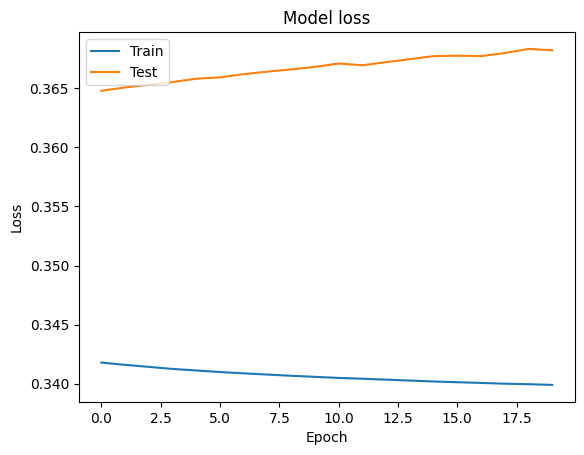

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()